In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [214]:
from torchtyping import TensorType as T


def make_dataset(
    centers: list[tuple[float, float]] = [(-0.5, 0), (0.5, 0)],
    size_each: int = 10_000,
    sigma: float = 0.07,
) -> list[T["size", 2, torch.float]]:  # noqa: F821
    points = []
    for x, y in centers:
        subset = torch.randn(size=(size_each, 2)) * sigma
        subset += torch.tensor([x, y])
        subset = subset.clip(min=-1, max=1)
        points.append(subset)
    return points

In [215]:
x = make_dataset(
    centers=[
        (-0.5, 0),
        (0.5, 0),
        (0.1, 0.3),
    ],
    sigma=0.05,
)

x = torch.cat(x)

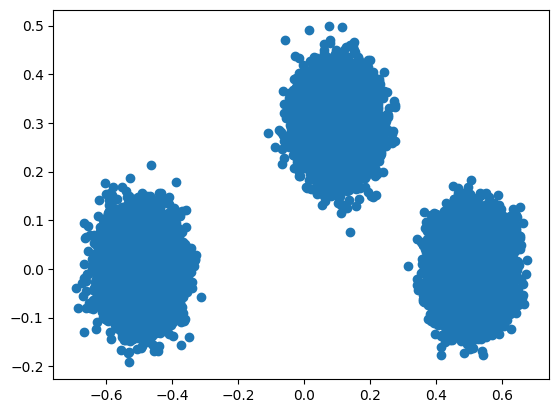

In [216]:
import matplotlib.pyplot as plt

plt.scatter(x=x[:, 0], y=x[:, 1])

In [217]:
import torch

X = torch.cat(make_dataset(size_each=1_000))

total_samples = X.size(0)

# Define the proportions for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Calculate the number of samples for each set
num_train = int(total_samples * train_ratio)
num_test = int(total_samples * test_ratio)
num_val = total_samples - num_train - num_test

# Generate random indices
indices = torch.randperm(total_samples)

# Split the indices into train, test, and validation sets
train_indices = indices[:num_train]
test_indices = indices[num_train : num_train + num_test]
val_indices = indices[num_train + num_test :]

# Create the train, test, and validation sets
X_train = X[train_indices]
X_test = X[test_indices]
X_val = X[val_indices]

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Validation set size:", X_val.shape)

Train set size: torch.Size([1600, 2])
Test set size: torch.Size([200, 2])
Validation set size: torch.Size([200, 2])


In [218]:
from diffusion import Scheduler, ForwardDiffusionProcess

max_T = 100
scheduler = Scheduler(T=max_T)
diffusion = ForwardDiffusionProcess(scheduler=scheduler)

In [231]:
from model import TimeEncoding


class DenoiserWithTime(nn.Module):
    def __init__(self, d_embed: int = 4, max_T: int = 100, d_hidden: int = 5):
        super().__init__()
        self.te = TimeEncoding(d_embed=d_embed, max_T=max_T)
        self.embed = nn.Linear(2, d_embed)
        self.layers = nn.Sequential(
            nn.Linear(d_embed, d_hidden),
            nn.ReLU(),
            nn.LayerNorm(d_hidden),
            # nn.Dropout(0.1),
            nn.Linear(d_hidden, 2),
            nn.ReLU(),
            nn.Softmax(dim=1),
        )

    def forward(
        self,
        x: T["b", 2, torch.float],  # noqa: F821
        t: T["b", torch.long],  # noqa: F821
    ) -> T["b", 2, torch.float]:  # noqa: F821
        xe = self.embed(x) + self.te(t)
        return self.layers(xe)

In [232]:
model = DenoiserWithTime(max_T=max_T, d_embed=10, d_hidden=15)

In [233]:
from torch.optim import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=0.001)

num_epochs = 10_000
n = X_train.shape[0]

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()

    x = X_train
    t = torch.randint(0, max_T, size=(n,))
    x_t = diffusion.sample_T(x, t)
    x_t_pred = model(x_t, t)

    loss = F.mse_loss(x_t_pred, x_t)

    loss.backward()
    optimizer.step()

    # validation

    model.eval()
    with torch.no_grad():
        n_test = X_test.shape[0]
        x_test = X_test
        t_test = torch.randint(0, max_T, size=(n_test,))
        x_t_test = diffusion.sample_T(x_test, t_test)
        x_t_pred_test = model(x_t_test, t_test)
        loss_test = F.mse_loss(x_t_test, x_test)
    if epoch % 1000 == 0:
        print(
            f"{epoch=}, train_loss={loss.item():2.4f}, test_loss={loss_test.item():2.4f}"
        )

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch=0, train_loss=0.4380, test_loss=0.1221
epoch=1000, train_loss=0.3555, test_loss=0.0966
epoch=2000, train_loss=0.3568, test_loss=0.0993
epoch=3000, train_loss=0.3605, test_loss=0.1154
epoch=4000, train_loss=0.3526, test_loss=0.1269
epoch=5000, train_loss=0.3561, test_loss=0.1584
epoch=6000, train_loss=0.3509, test_loss=0.1210
epoch=7000, train_loss=0.3570, test_loss=0.1136
epoch=8000, train_loss=0.3706, test_loss=0.1171
epoch=9000, train_loss=0.3536, test_loss=0.0860


In [234]:
def sample(self, model: nn.Module, n: int, max_T: int):
    model.eval()
    with torch.no_grad():
        noise_probs = torch.randint(
            low=0, high=model.alphabet_size, size=(n, model.n_tokens)
        ).float()

        for t in reversed(range(max_T)):
            t = (torch.ones(n) * t).long()
            x = predicted_probs = model(noise_probs, t)

            alpha = self.scheduler.get_alphas(t).reshape(-1, 1, 1)
            alphabar = self.scheduler.get_alphabar(t).reshape(-1, 1, 1)
            beta = self.scheduler.get_betas(t).reshape(-1, 1, 1)
            noise = torch.randn_like(x)

            x = (
                1
                / torch.sqrt(alpha)
                * (x - ((1 - alpha) / (torch.sqrt(1 - alphabar))) * x)
                + torch.sqrt(beta) * noise
            )

    return predicted_probs

AttributeError: 'DenoiserWithTime' object has no attribute 'alphabet_size'